In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import datetime
import seaborn as sns
import pydicom
import time
import gc
import operator 
from apex import amp 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as D
import torch.nn.functional as F
from sklearn.model_selection import KFold
from tqdm import tqdm, tqdm_notebook
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings(action='once')
import pickle
%load_ext autoreload
%autoreload 2
%matplotlib inline
from skimage.io import imread,imshow
from helper import *
from apex import amp
import helper
import torchvision.models as models
from torch.optim import Adam
from defenitions import *

/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/home/reina/anaconda3/envs/RSNA/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


In [2]:
SEED = 4356477
device=device_by_name("Tesla")
#device=device_by_name("RTX")
#device = "cpu"

In [3]:
def get_submission(test_df,pred):
    epidural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_epidural','Label':torch.sigmoid(pred[:,0])})
    intraparenchymal_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraparenchymal','Label':torch.sigmoid(pred[:,1])})
    intraventricular_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_intraventricular','Label':torch.sigmoid(pred[:,2])})
    subarachnoid_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subarachnoid','Label':torch.sigmoid(pred[:,3])})
    subdural_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_subdural','Label':torch.sigmoid(pred[:,4])})
    any_df=pd.DataFrame(data={'ID':'ID_'+test_df.PatientID.values+'_any','Label':torch.sigmoid(pred[:,5])}) 
    return pd.concat([epidural_df,
                        intraparenchymal_df,
                        intraventricular_df,
                        subarachnoid_df,
                        subdural_df,
                        any_df]).sort_values('ID').reset_index(drop=True)

In [4]:
train_df = pd.read_csv(data_dir+'train.csv')
train_df=train_df[~train_df.PatientID.isin(bad_images)].reset_index(drop=True)
train_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,PID,StudyI,SeriesI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,63eb1e259,0,0,0,0,0,0,a449357f,62d125e5b2,0be5c0d1b3,"['00036', '00036']","['00080', '00080']",180.199951,-125.0,-8.000000
1,2669954a7,0,0,0,0,0,0,363d5865,a20b80c7bf,3564d584db,"['00047', '00047']","['00080', '00080']",922.530821,-156.0,45.572849
2,52c9913b1,0,0,0,0,0,0,9c2b4bd7,3e3634f8cf,973274ffc9,40,150,4.455000,-125.0,-115.063000
3,4e6ff6126,0,0,0,0,0,0,3ae81c2d,a1390c15c2,e5ccad8244,"['00036', '00036']","['00080', '00080']",100.000000,-99.5,28.500000
4,7858edd88,0,0,0,0,0,0,c1867feb,c73e81ed3a,28e0531b3a,40,100,145.793000,-125.0,-132.190000


In [5]:
test_df = pd.read_csv(data_dir+'test.csv')
test_df.head()

,PatientID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,any,SeriesI,PID,StudyI,WindowCenter,WindowWidth,ImagePositionZ,ImagePositionX,ImagePositionY
0,28fbab7eb,0.5,0.5,0.5,0.5,0.5,0.5,ebfd7e4506,cf1b6b11,93407cadbb,30,80,158.458000,-125.0,-135.598000
1,877923b8b,0.5,0.5,0.5,0.5,0.5,0.5,6d95084e15,ad8ea58f,a337baa067,30,80,138.729050,-125.0,-101.797981
2,a591477cb,0.5,0.5,0.5,0.5,0.5,0.5,8e06b2c9e0,ecfb278b,0cfe838d54,30,80,60.830002,-125.0,-133.300003
3,42217c898,0.5,0.5,0.5,0.5,0.5,0.5,e800f419cf,e96e31f4,c497ac5bad,30,80,55.388000,-125.0,-146.081000
4,a130c4d2f,0.5,0.5,0.5,0.5,0.5,0.5,faeb7454f3,69affa42,854e4fbc01,30,80,33.516888,-125.0,-118.689819


In [6]:
split = train_df.SeriesI.unique()
np.random.seed(SEED)
np.random.shuffle(split)
split_train=split[:int(0.9*split.shape[0])]
split_val=split[int(0.9*split.shape[0]):]

idx_train = train_df[train_df.SeriesI.isin(set(split_train))].index.values
idx_validate = train_df[train_df.SeriesI.isin(set(split_val))].index.values
idx_train.shape
idx_validate.shape

(606863,)

(67641,)

In [7]:
def my_loss(y_pred,y_true,weights):
    return F.binary_cross_entropy_with_logits(y_pred,y_true,weights.repeat(y_pred.shape[0],1))

In [8]:
class parameter_scheduler():
    def __init__(self,model,do_first=['classifier'],num_epoch=1):
        self.model=model
        self.do_first = do_first
        self.num_epoch=num_epoch
    def __call__(self,epoch):
        if epoch>=self.num_epoch:
            for n,p in self.model.named_parameters():
                p.requires_grad=True
        else:
            for n,p in self.model.named_parameters():
                p.requires_grad= any(nd in n for nd in self.do_first)


In [9]:
def get_optimizer_parameters(model,klr):
    zero_layer=['conv0','norm0']
    param_optimizer = list(model.named_parameters())
    num_blocks=4
    no_decay=['bias']
    optimizer_grouped_parameters=[
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and any(nd in n for nd in zero_layer))], 'lr':klr*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and any(nd in n for nd in zero_layer)], 'lr':klr*2e-5, 'weight_decay': 0.0}
        ]
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('classifier' in n))], 'lr':klr*1e-3,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('classifier' in n)], 'lr':klr*1e-3, 'weight_decay': 0.0}
        ])
    for i in range(num_blocks):
        optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('denseblock{}'.format(i+1) in n))], 'lr':klr*(2.0**i)*2e-5,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('denseblock{}'.format(i+1) in n)], 'lr':klr*(2.0**i)*2e-5, 'weight_decay': 0.0}
        ])
    optimizer_grouped_parameters.extend([
        {'params': [p for n, p in param_optimizer if (not any(nd in n for nd in no_decay) and ('norm5' in n))], 'lr':klr*1e-4,'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)  and ('norm5' in n)], 'lr':klr*1e-4, 'weight_decay': 0.0}
        ])
    return(optimizer_grouped_parameters)

    

<IPython.core.display.Javascript object>


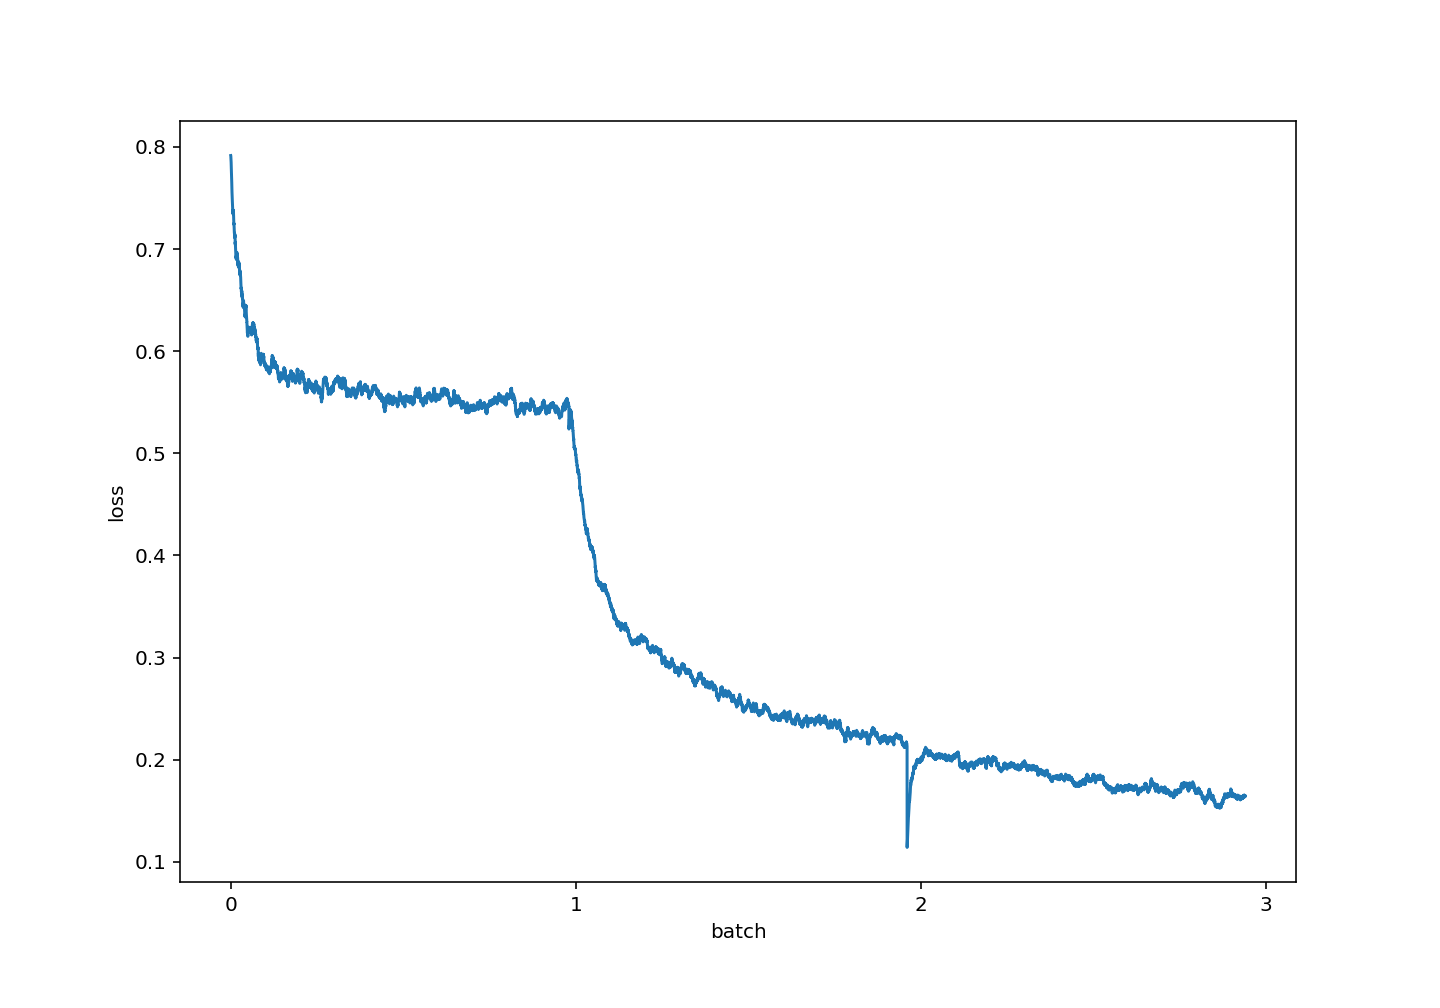

{'loss': 0.545849730652244, 'val_loss': 0.277551674469953}


{'loss': 0.21322927353709972, 'val_loss': 0.10638482531210162}


{'loss': 0.16435006732942317, 'val_loss': 0.10870379018319758}

0.10638482531210162


In [9]:
%matplotlib nbagg

num_split=1
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=3
batch_size=32
num_workers=12
num_epochs=3
model_name,version = 'Densenet161' , 'basic'
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs//3,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=model.parameter_scheduler,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=sampling,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

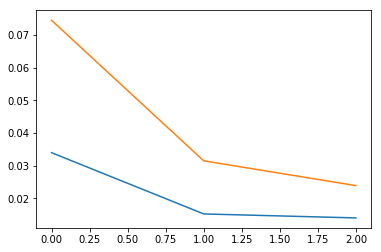

In [9]:
 plt.plot(np.array([[hist['val_loss'] for hist in history],[hist['loss'] for hist in history]]).transpose())

<IPython.core.display.Javascript object>


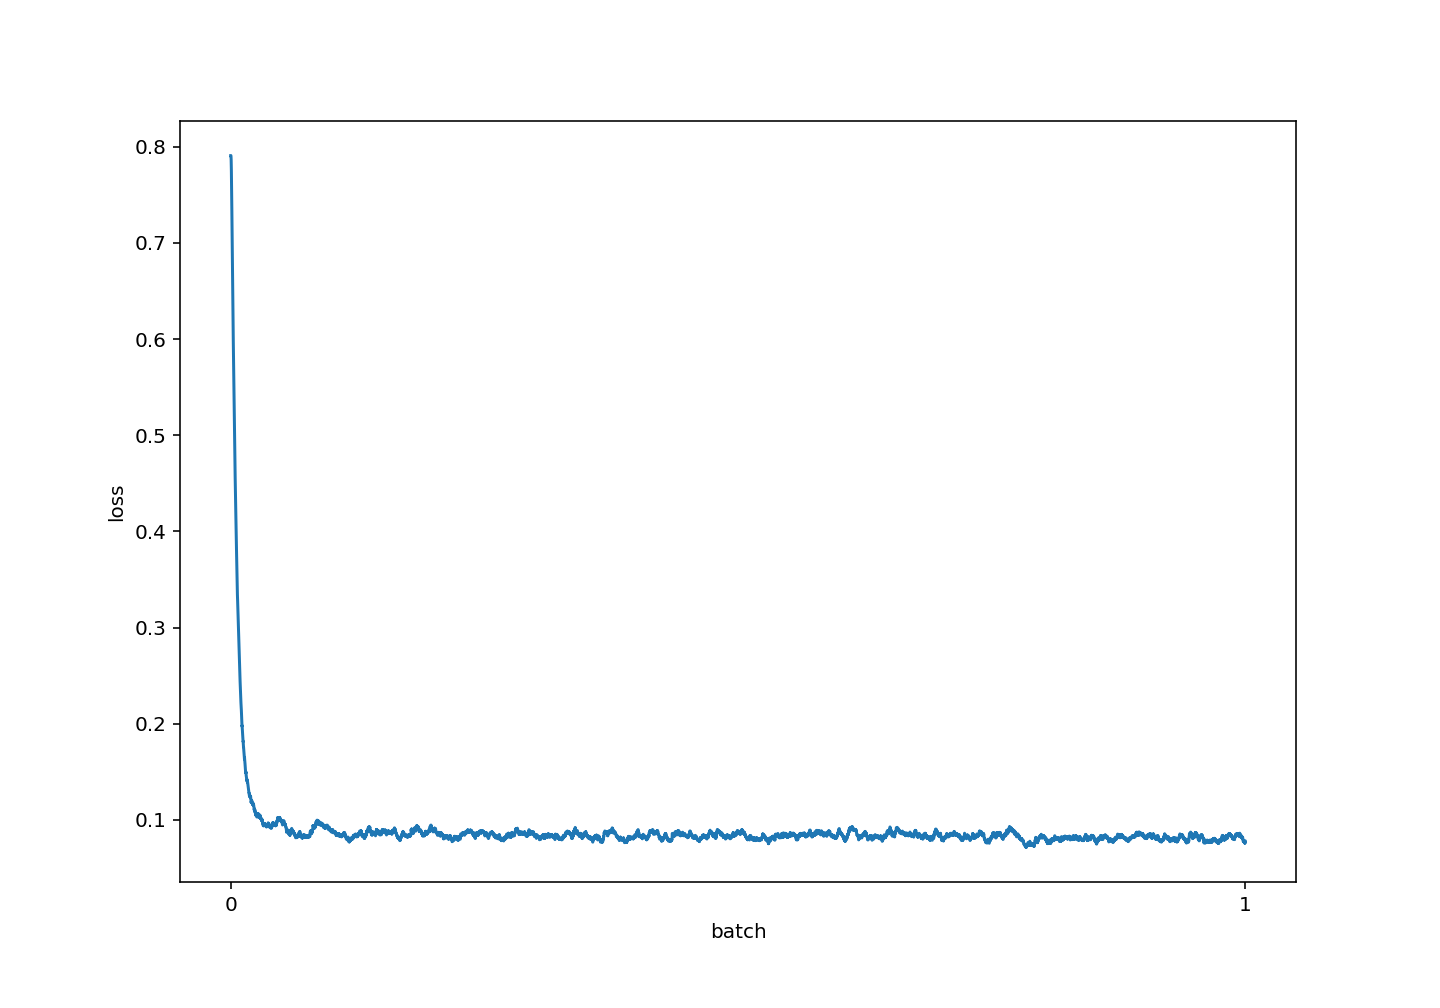

{'loss': 0.07753208932036099, 'val_loss': 0.08208299972490975}
0.08208299972490975


In [10]:
%matplotlib nbagg

num_split=1
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=0.3
batch_size=32
num_workers=12
num_epochs=1
model_name,version = 'Densenet161' , 'basic_classifier'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=0)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

<IPython.core.display.Javascript object>


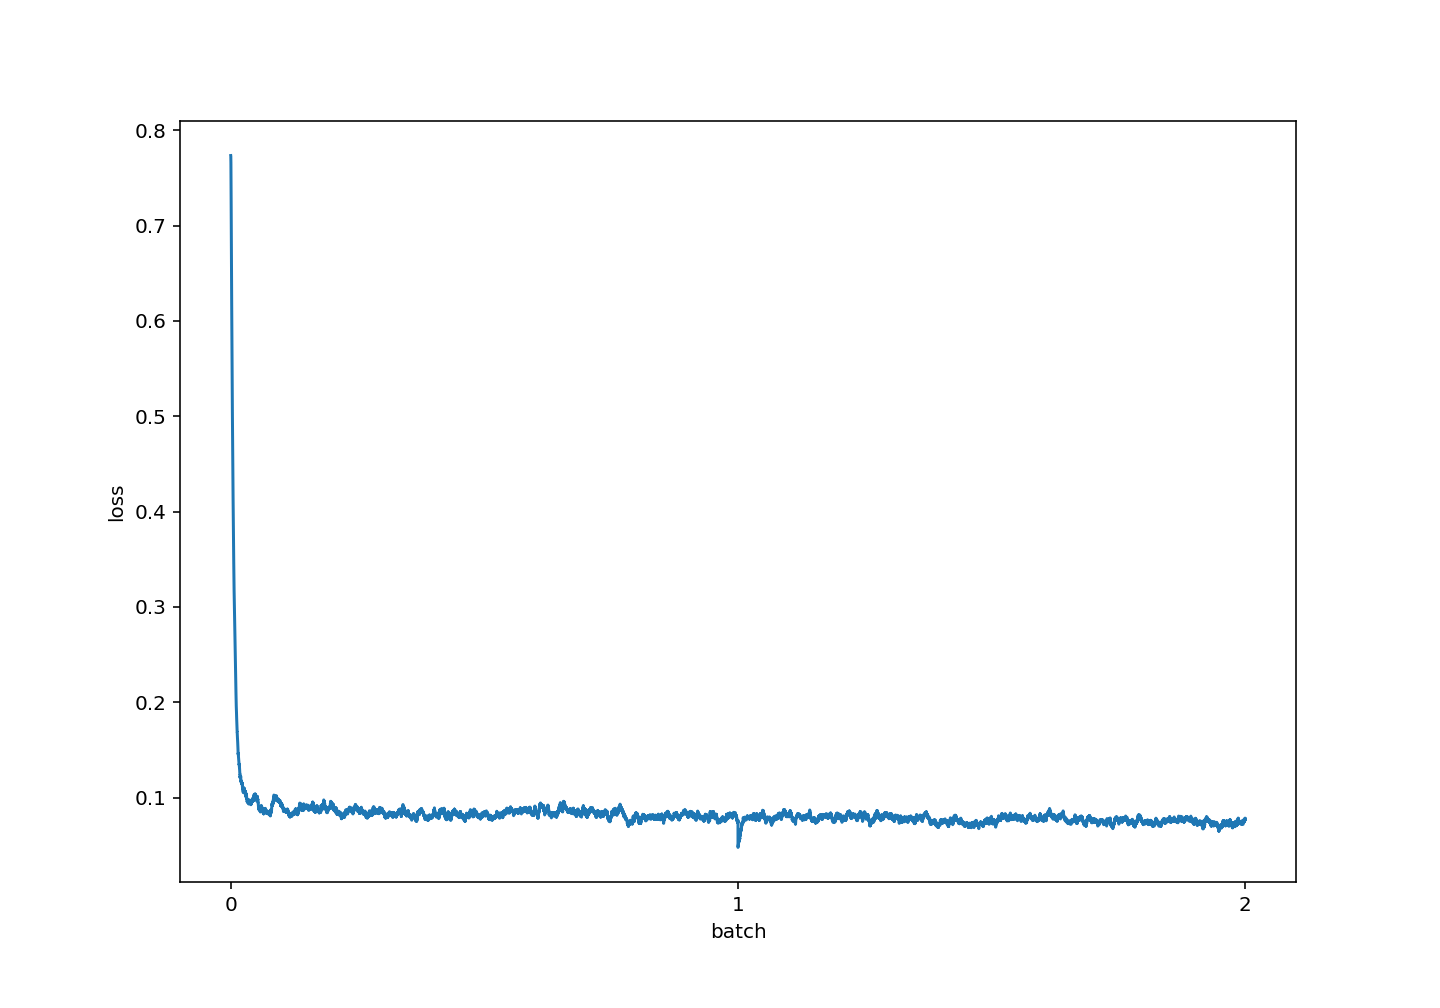

{'loss': 0.0771671923345742, 'val_loss': 0.08021051547505038}
0.08021051547505038


In [9]:
%matplotlib nbagg

num_split=1
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=32
num_workers=12
num_epochs=2
model_name,version = 'Densenet161' , 'basic_more'
model1 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model1.load_state_dict(torch.load(models_dir+models_format.format(model_name,'basic_classifier',num_split),map_location=torch.device(device)))
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model.features = model1.features
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
targets_dataset=D.TensorDataset(torch.tensor(train_df[hemorrhage_types].values,dtype=torch.float))
transform=MyTransform(flip=True,zoom=0.05,rotate=15,out_size=512,shift=40)
imagedataset = ImageDataset(train_df,transform=transform.random,base_path=train_images_dir)
transform_val=MyTransform(out_size=512)
imagedataset_val = ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
combined_dataset=DatasetCat([imagedataset,targets_dataset])
combined_dataset_val=DatasetCat([imagedataset_val,targets_dataset])
#param_s=parameter_scheduler(model,num_epoch=0)
optimizer_grouped_parameters=get_optimizer_parameters(model,klr)
#sampling=sampler(train_df[hemorrhage_types].values[idx_train],0.2,[10,1,1,1,1,0])
sample_ratio=1.0 #1.02*float(sampling().shape[0])/idx_train.shape[0]
train_dataset=D.Subset(combined_dataset,idx_train)
validate_dataset=D.Subset(combined_dataset_val,idx_validate)
num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,int(num_train_optimization_steps/num_epochs)+1)
sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs*2,tau=1)
optimizer = BertAdam(optimizer_grouped_parameters,lr=klr*1e-3,schedule=sched)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=True,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)

torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [10]:
history

[{'loss': 0.07565907857467119, 'val_loss': 0.08065622635630675},
 {'loss': 0.0771671923345742, 'val_loss': 0.08021051547505038}]

In [ ]:
model_name,version,num_split = 'Densenet161' , 'basic_more',1
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=512)
train_dataset=ImageDataset(train_df,transform=transform_val.random,base_path=train_images_dir)
pred,features = model_run(model,train_dataset,do_apex=True,batch_size=96,num_workers=12)

pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_train',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()

my_loss(pred[idx_validate],
        torch.tensor(train_df[hemorrhage_types].values[idx_validate],dtype=torch.float),
        torch.tensor([1.,1.,1.,1.,1.,2.]))

In [20]:
model_name,version,num_split = 'Densenet161' , 'basic_more',1
model = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types),return_features=True)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model.to(device)
transform_val=MyTransform(out_size=512)
imagedataset_test=ImageDataset(test_df,transform=transform_val.random,base_path=test_images_dir)
pred,features = model_run(model,imagedataset_test,do_apex=True,batch_size=96,num_workers=12)
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'wb')
pickle.dump(features,pickle_file,protocol=4)
pickle_file.close()
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'predictions_test',num_split),'wb')
pickle.dump(pred,pickle_file,protocol=4)
pickle_file.close()

In [22]:
submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=12
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,2.350483e-03
1,ID_000012eaf_epidural,1.517511e-06
2,ID_000012eaf_intraparenchymal,5.152657e-04
3,ID_000012eaf_intraventricular,7.197912e-05
4,ID_000012eaf_subarachnoid,7.014083e-04
5,ID_000012eaf_subdural,1.775261e-03
6,ID_0000ca2f6_any,3.640087e-04
7,ID_0000ca2f6_epidural,2.299383e-09
8,ID_0000ca2f6_intraparenchymal,3.101560e-04
9,ID_0000ca2f6_intraventricular,1.331558e-05


(471270, 2)

/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


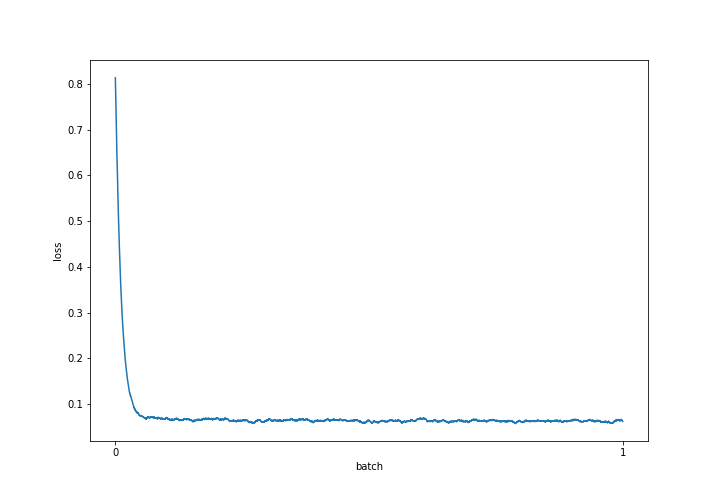

{'loss': 0.06240594737389429, 'val_loss': 0.07246114826226359}

0.07246114826226359


In [10]:
%matplotlib nbagg
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
train_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_train)
validate_dataset=D.Subset(FeatursDataset(train_df,features,num_neighbors,'SeriesI','ImagePositionZ',hemorrhage_types),idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [12]:
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=13
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


/home/reina/anaconda3/envs/RSNA/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


<IPython.core.display.Javascript object>


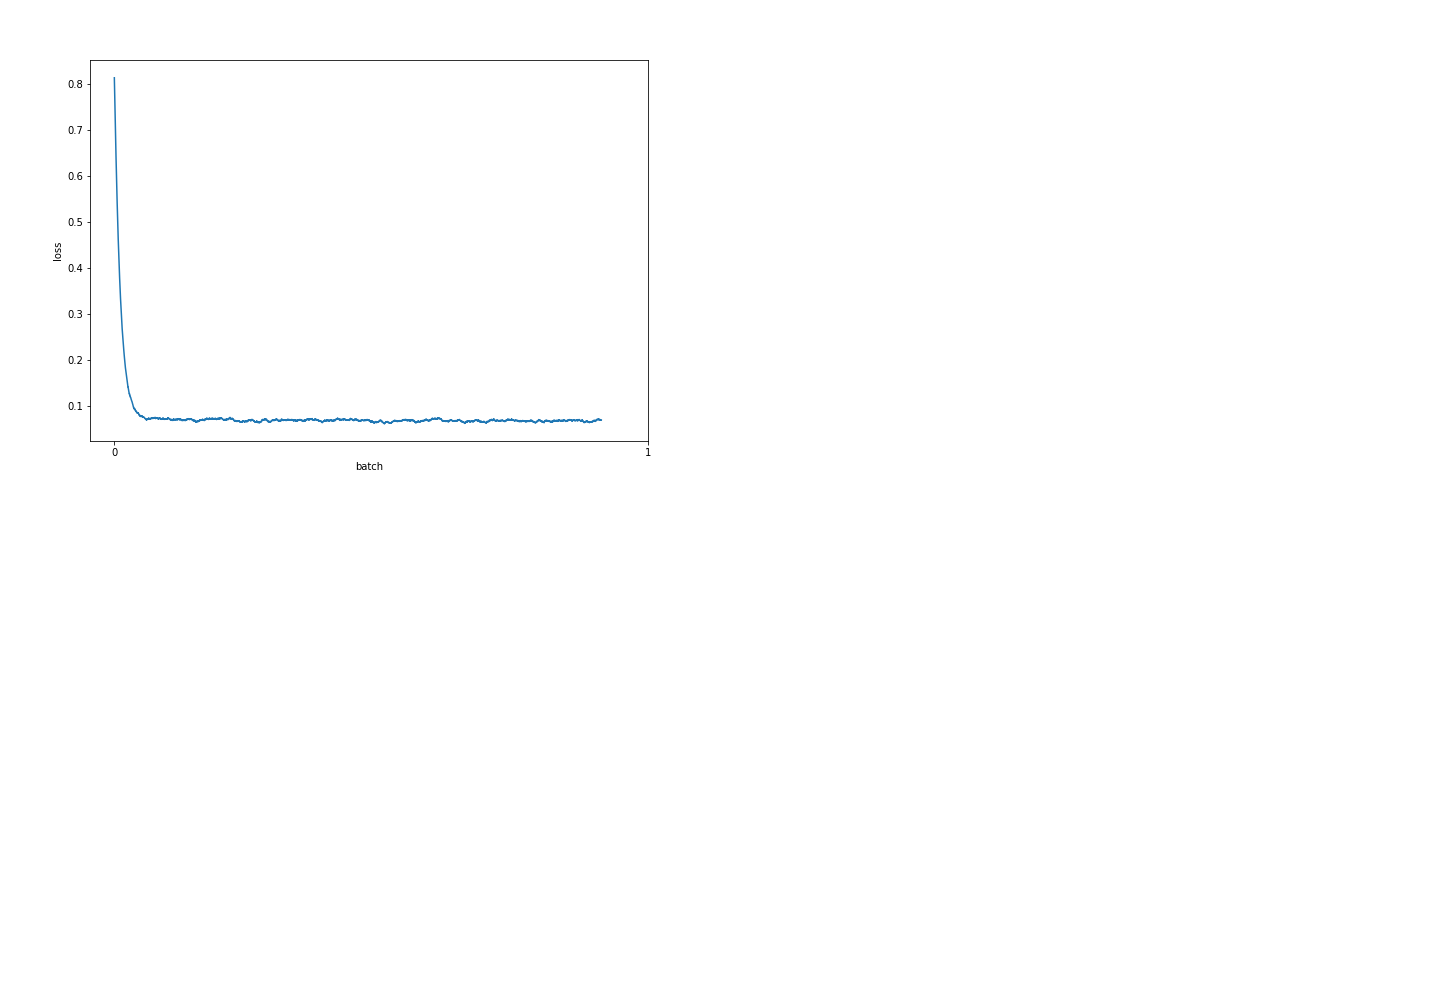

In [ ]:
%matplotlib nbagg
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [11]:
history

[{'loss': 0.06587706119497523, 'val_loss': 0.07803411413135682}]

In [13]:
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}cor'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDatasetCor(test_df,features,num_neighbors,'SeriesI')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=16
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,3.987363e-03
1,ID_000012eaf_epidural,3.184440e-05
2,ID_000012eaf_intraparenchymal,1.870280e-04
3,ID_000012eaf_intraventricular,2.308862e-05
4,ID_000012eaf_subarachnoid,4.100102e-03
5,ID_000012eaf_subdural,1.462754e-03
6,ID_0000ca2f6_any,3.231668e-04
7,ID_0000ca2f6_epidural,2.319840e-07
8,ID_0000ca2f6_intraparenchymal,1.277921e-04
9,ID_0000ca2f6_intraventricular,1.026345e-06


(471270, 2)

<IPython.core.display.Javascript object>


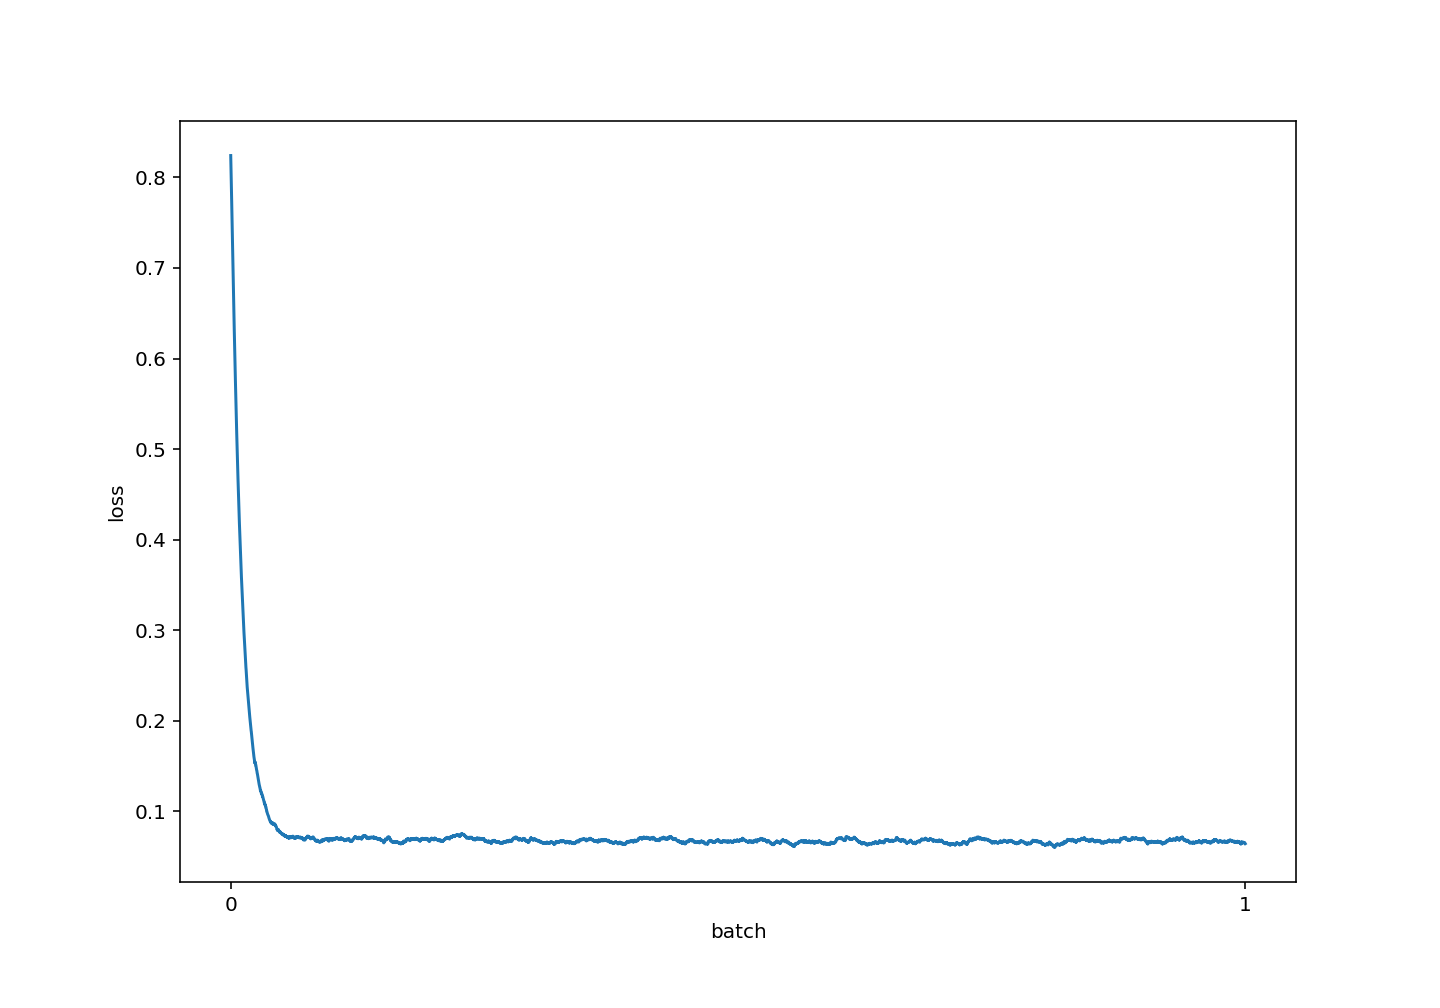

{'loss': 0.06437657827201802, 'val_loss': 0.07674284156521143}

0.07674284156521143


In [15]:
%matplotlib nbagg
num_neighbors=3
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [17]:
num_neighbors=3
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}cor'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDatasetCor(test_df,features,num_neighbors,'SeriesI')
pred = model_run(model,test_dataset,do_apex=False,batch_size=512)

submission_df=get_submission(test_df,pred)
submission_df.head(12)
submission_df.shape
sub_num=17
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,3.595988e-03
1,ID_000012eaf_epidural,6.519349e-07
2,ID_000012eaf_intraparenchymal,1.049840e-03
3,ID_000012eaf_intraventricular,3.327167e-05
4,ID_000012eaf_subarachnoid,1.500288e-04
5,ID_000012eaf_subdural,2.039619e-03
6,ID_0000ca2f6_any,5.662431e-04
7,ID_0000ca2f6_epidural,5.773299e-09
8,ID_0000ca2f6_intraparenchymal,1.116902e-03
9,ID_0000ca2f6_intraventricular,3.820406e-06


(471270, 2)

<IPython.core.display.Javascript object>


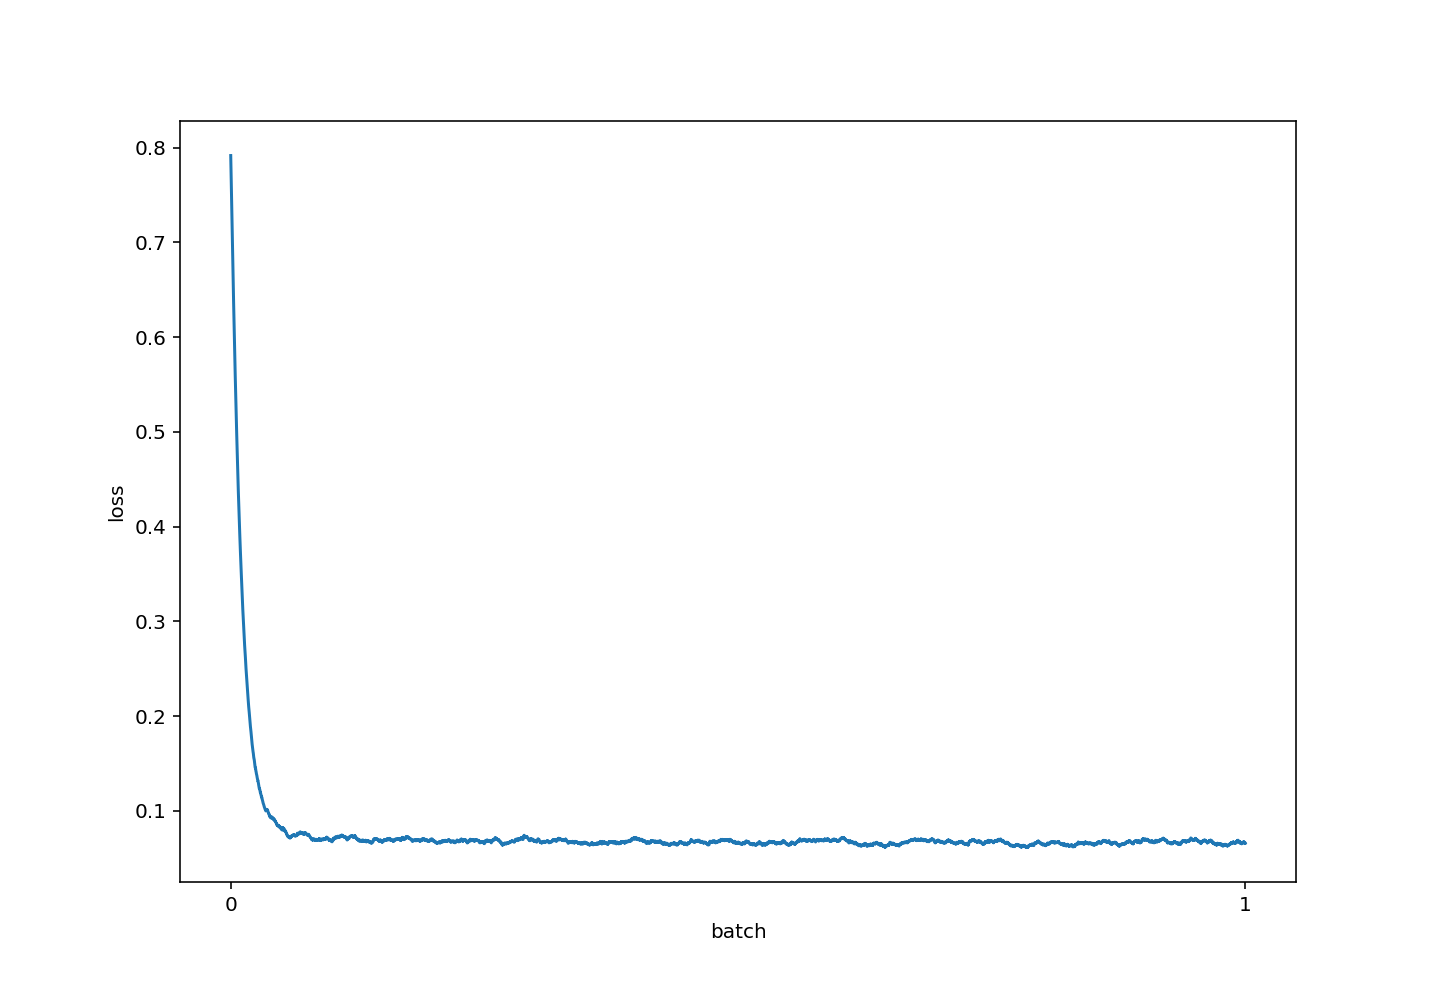

{'loss': 0.06605889454732886, 'val_loss': 0.07685580980931404}

0.07685580980931404


In [16]:
%matplotlib nbagg
num_neighbors=4
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
np.random.seed(SEED+num_split)
torch.manual_seed(SEED+num_split)
torch.cuda.manual_seed(SEED+num_split)
torch.backends.cudnn.deterministic = True
klr=1
batch_size=64
num_workers=1
num_epochs=1
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
model0.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),
                   num_neighbors=num_neighbors,
                   num_features=model0.classifier.in_features,
                   intermidiate=128, 
                   dropout=0.5)


version=version+'_neighbors{}cor'.format(num_neighbors)
_=model.to(device)
weights = torch.tensor([1.,1.,1.,1.,1.,2.],device=device)
loss_func=my_loss
param_optimizer = model.parameters()
features_dataset=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)
train_dataset=D.Subset(features_dataset,idx_train)
validate_dataset=D.Subset(features_dataset,idx_validate)
fig,ax = plt.subplots(figsize=(10,7))
gr=loss_graph(fig,ax,num_epochs,len(train_dataset)//batch_size+1)
#num_train_optimization_steps = num_epochs*(sample_ratio*len(train_dataset)//batch_size+int(len(train_dataset)%batch_size>0))
#sched=WarmupExpCosineWithWarmupRestartsSchedule( t_total=num_train_optimization_steps, cycles=num_epochs,tau=0)
optimizer = torch.optim.Adam(param_optimizer, lr=0.001)
history,best_model= model_train(model,
                                optimizer,
                                train_dataset,
                                batch_size,
                                num_epochs,
                                loss_func,
                                weights=weights,
                                do_apex=False,
                                validate_dataset=validate_dataset,
                                param_schedualer=None,
                                weights_data=None,
                                metric=None,
                                return_model=True,
                                num_workers=num_workers,
                                sampler=None,
                                graph=gr)
torch.save(best_model.state_dict(), models_dir+models_format.format(model_name,version,num_split))

In [15]:
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',0
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_test',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()
model0 = MyDenseNet(models.densenet161(pretrained=True),len(hemorrhage_types))
_=model0.to('cpu')
model=NeighborsNet(len(hemorrhage_types),num_neighbors=num_neighbors,
                   classifier_layer=model0.classifier,intermidiate=128)
version=version+'_neighbors{}in'.format(num_neighbors)
model.load_state_dict(torch.load(models_dir+models_format.format(model_name,version,num_split),map_location=torch.device(device)))
test_dataset=FeatursDataset(test_df,features,num_neighbors,'SeriesI','ImagePositionZ')
pred1 = model_run(model,test_dataset,do_apex=False,batch_size=512)

In [16]:
pred12=(pred+pred1)/2

In [18]:
submission_df=get_submission(test_df,pred12)
submission_df.head(12)
submission_df.shape
sub_num=15
submission_df.to_csv('/media/hd/notebooks/data/RSNA/submissions/submission{}.csv'.format(sub_num),
                                                                  index=False, columns=['ID','Label'])


,ID,Label
0,ID_000012eaf_any,9.468388e-04
1,ID_000012eaf_epidural,2.550654e-07
2,ID_000012eaf_intraparenchymal,7.998909e-05
3,ID_000012eaf_intraventricular,1.923697e-06
4,ID_000012eaf_subarachnoid,2.873279e-04
5,ID_000012eaf_subdural,1.944915e-04
6,ID_0000ca2f6_any,2.628130e-04
7,ID_0000ca2f6_epidural,2.992015e-08
8,ID_0000ca2f6_intraparenchymal,3.788976e-05
9,ID_0000ca2f6_intraventricular,2.022479e-07


(471270, 2)

In [10]:
num_neighbors=2
model_name,version,num_split = 'Densenet161' , 'basic_more',1
pickle_file=open(outputs_dir+outputs_format.format(model_name,version,'features_train',num_split),'rb')
features=pickle.load(pickle_file)
pickle_file.close()


In [11]:
ft=FeatursDatasetCor(train_df,features,num_neighbors,'SeriesI',hemorrhage_types)

In [10]:
train_df[train_df.SeriesI==sids[0]].shape

(47, 15)

In [57]:
num_neighbors=2
df=train_df
ref_column='SeriesI'
ref_arr=np.zeros((df.shape[0],1+2*num_neighbors),dtype=np.long)
series_ids = df[ref_column].unique()

unq,si=np.unique(train_df.SeriesI.values,return_inverse=True)
for i in tqdm_notebook(range(unq.shape[0]), leave=False):
    sinx = np.where(si==i)[0]
    r=np.corrcoef(features[sinx].numpy())
    ref_arr[sinx]=sinx[np.argsort(-r)][:,:1+2*num_neighbors]


In [58]:
ref_arr[:10]

array([[     0, 603407, 658079, 654445, 664090],
       [     1, 549875, 575318, 592885, 358986],
       [     2,  84667, 476989, 504994, 386426],
       [     3,  86351, 482566, 311173, 231371],
       [     4, 374861, 568547, 507845, 242399],
       [     5, 455231, 452917, 290083, 502051],
       [     6, 589771, 604477, 344939, 501387],
       [     7, 270578,  73794, 568589, 452488],
       [     8, 528050, 332494, 514677, 467564],
       [     9, 117794, 520336, 529937, 285865]])

In [68]:
(ref_arr==0).sum()

6

In [27]:
gp = df.groupby(by='SeriesI')


KeyError: 'Column not found: 0be5c0d1b3'

In [20]:
sinxs = [df[df[ref_column]==sid].index.values for sid in tqdm_notebook(series_ids, leave=False)]

KeyboardInterrupt: 

In [18]:
sids = train_df.SeriesI.unique()
sinx = train_df[train_df.SeriesI==sids[0]].index.values
r=np.corrcoef(features[sinx].numpy())
sinx[np.argsort(-r)[:,:5]]
#train_df.ImagePositionZ.values[sinx[a]][:,:5]

array([[     0, 603407, 658079, 654445, 664090],
       [  4459, 390618, 340675, 123342, 548532],
       [ 31739, 354664, 394905,  52194, 491435],
       [ 42713, 214482, 219248, 200865, 450873],
       [ 52194, 394905,  31739, 491435, 354664],
       [ 81545, 623343, 250072, 151270, 506712],
       [ 81825, 559788, 173338, 165565, 354664],
       [ 98562, 276723, 525033, 491435,  31739],
       [123342, 390618,   4459, 340675, 548532],
       [151270, 250072, 641947, 506712, 229578],
       [165565, 442522,  81825, 173338, 354664],
       [173338,  31739,  81825, 354664, 394905],
       [193445, 654445, 360185, 194298, 262041],
       [194298, 664090, 123342, 603407, 654445],
       [200865, 214482,  42713, 548532, 450873],
       [214482,  42713, 200865, 450873, 219248],
       [219248, 450873,  42713, 214482, 603407],
       [229578, 219248, 200865, 250072,  42713],
       [250072, 151270, 506712, 229578, 641947],
       [262041, 360185, 410394, 193445, 194298],
       [276723,  985

In [56]:
sids_ = train_df.SeriesI.values
sids,si=np.unique(sids_,return_inverse=True)
si.shape

(674504,)

In [46]:
sids[:10]
sinv[:10]
sids_[:10]

array(['0000298a7d', '0004c4e54c', '000a935543', '000f6fd7db',
       '001231935f', '00175b0c48', '0018a8a4a8', '001a368147',
       '002bc432f1', '002c873783'], dtype=object)

array([26378, 38931, 19874, 12743, 29937, 15212, 33677,  1304, 22750,
         174])

array(['0be5c0d1b3', '3564d584db', '973274ffc9', 'e5ccad8244',
       '28e0531b3a', 'd746de32da', '46fcb3c0fe', '77942bf055',
       '95a76cfccd', '1d3a3d6c53'], dtype=object)

In [47]:
sinv[0]
sids_[sinv[0]]
train_df.SeriesI.values[0]


26378

'0000298a7d'

'0be5c0d1b3'

In [48]:

np.where(si==0)[0]

array([ 26378,  28773,  70428, 156061, 161639, 170173, 204547, 209859,
       237374, 245160, 257854, 291844, 316423, 318855, 333442, 337479,
       348141, 348623, 390640, 401443, 409469, 428982, 433730, 457952,
       489285, 504807, 521789, 526460, 540067, 547252, 556089, 569154,
       579564, 612476, 616115, 624954, 627588, 632616, 637303, 658971])

In [31]:
sids

array(['0000298a7d', '0004c4e54c', '000a935543', ..., 'fff54f5625',
       'fff5a1c893', 'fff6bd92fb'], dtype=object)